# Предсказание временного ряда

На основании исторических данных компании «Чётенькое такси» о заказах такси в аэропортах спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

Задача: построить модель такого предсказания.

Цель: значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
sns.set()

# 1 Загрузка данных и ресемплирование по одному часу

Загружаем датасет:

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

Смотрим первые 5 строк:

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Посмотрим информацию по загруженным данным:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Нужно сделать столбец datetime индексом, приведя его к типу datetime:

In [5]:
# сделаем дату и время индексом
data.set_index(pd.DatetimeIndex(data['datetime']), inplace=True)

# удалим столбец datetime
data.drop('datetime', axis=1, inplace=True)

# напечатаем информацию по таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Построим график:

In [7]:
def plot_fig(data):
    plt.figure(figsize=(16, 8))
    plt.plot(data, 'r', label='Количество заказов')
    plt.legend()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


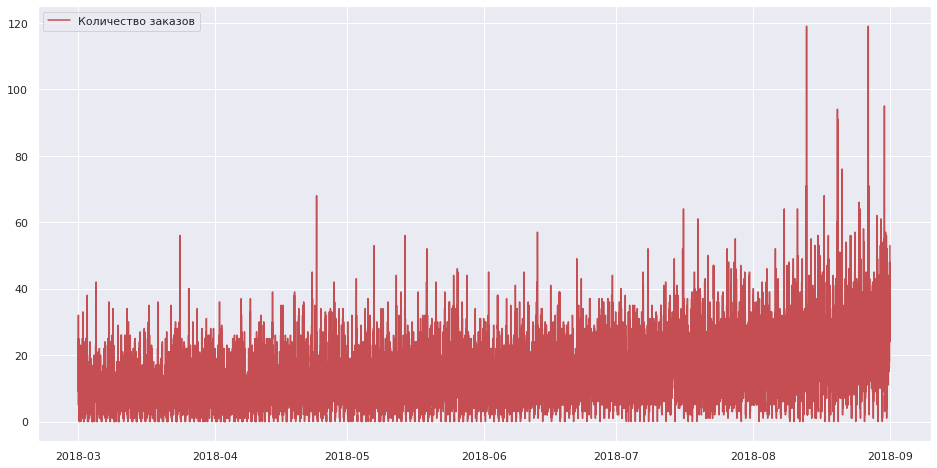

In [8]:
plot_fig(data)

Выполним ресемплирование по одному часу, агрегируем значения суммой, так как интересны суммарные заказы за час:

In [9]:
df_resample = data.resample('1H').sum()

Построим график:

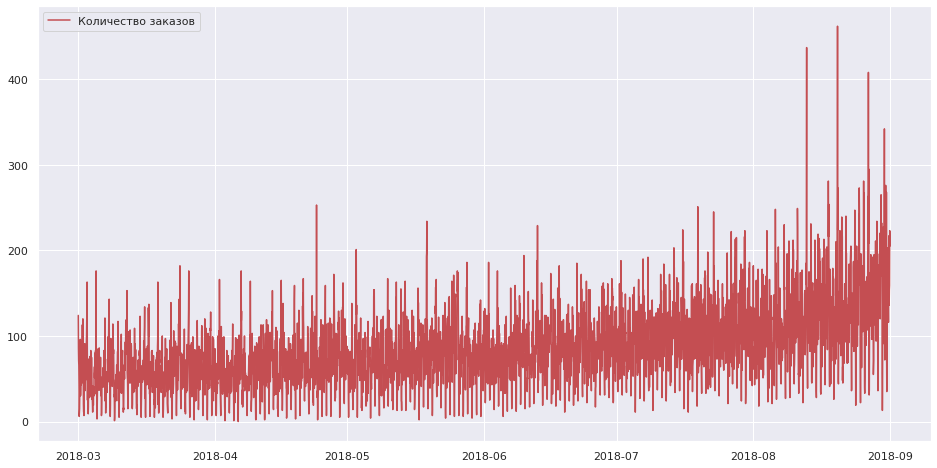

In [10]:
plot_fig(df_resample)

### Выводы:

1. В загруженных данных преобразованы индексы в объекты DatetimeIndex, удален столбец с датой.
2. Выполнено ресемплирование по одному часу с агрегированием по среднему - плотность графика немного уменьшилась, даже визуально можно проследить тренд (грубо).

# 2 Анализ данных

Так как это временной ряд, можно попробовать определить тренд и сезонность. Для начала изобразим скользящее среднее на полученном графике:

In [11]:
# мы имеем шаг ресемплирования в 1 час, выберем размер окна, равным 24 (один день)
def plot_roll(data):
    plot_fig(data)
    plt.plot(data.rolling(24).mean(), label='Скользящее среднее')
    plt.legend();

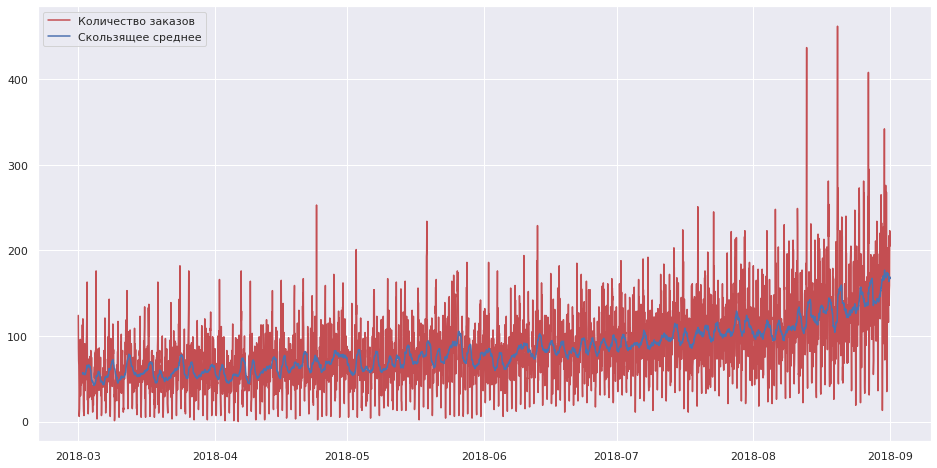

In [12]:
plot_roll(df_resample)

Каждый день есть некие пиковые значения по заказам. Возьмем интервал в 1 неделю и в 1 день, например, в июне и посмотрим на данные:

In [13]:
# интервал в 1 неделю
df_week = df_resample['2018-04-09':'2018-04-16']

# интервал в 1 день
df_day = df_resample['2018-06-09':'2018-06-10']

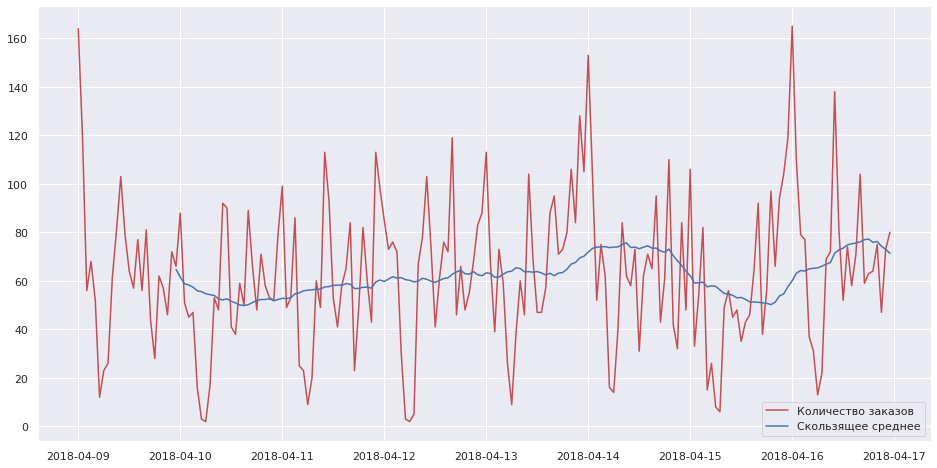

In [14]:
plot_roll(df_week)

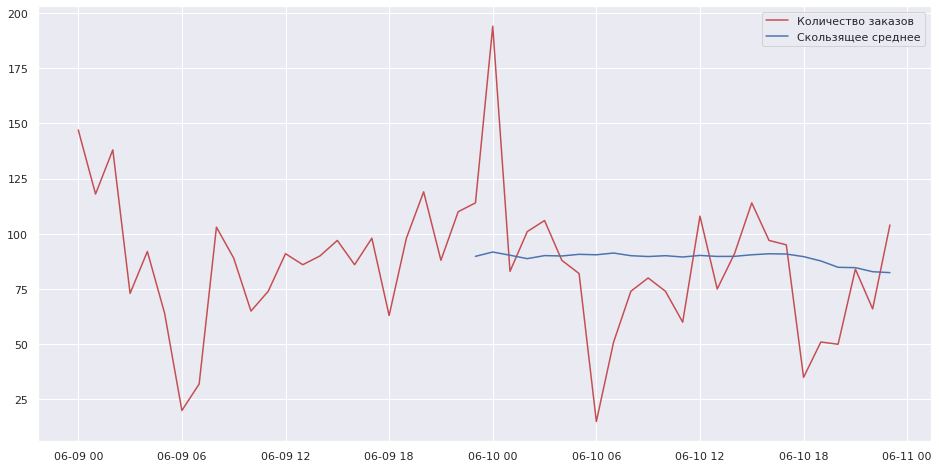

In [15]:
plot_roll(df_day)

### Выводы:

1. Пик заказов - в полночь.
2. Минимальные заказы в период с 4 до 6 утра, причем с 6 утра резкий рост заказов - люди едут на работу.
3. В течении дня количество заказов колеблется в пределах некоторой величины без серьезных выбросов.

Разобъем ряд на части с помощью seasonal_decompose модуля statsmodels, используем данные за 1 месяц:

In [16]:
decomposed = seasonal_decompose(df_week)

Отобразим тренд, сезонность и остатки преобразования:

In [17]:
def plot_decompose(decomposed):
    plt.figure(figsize=(14, 16))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Тренд')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Сезонность')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Остатки преобразования')
    plt.subplots_adjust(hspace=0.5)

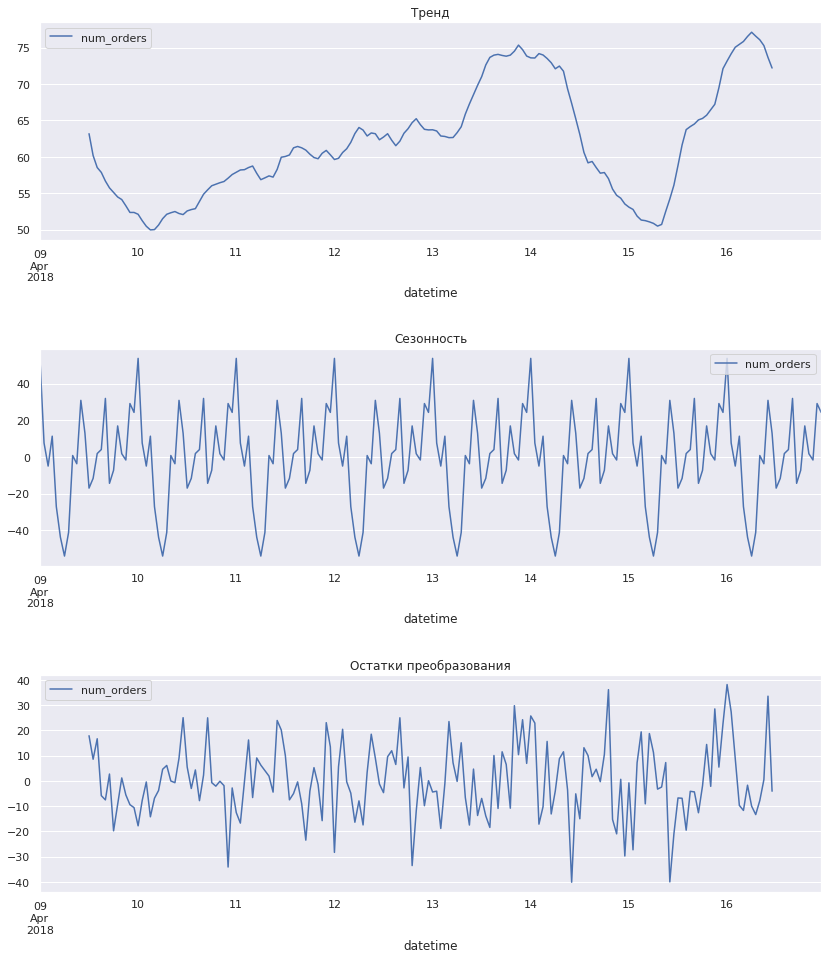

In [18]:
plot_decompose(decomposed)

### Выводы:

1. Количество заказов в течении недели растет до полуночи в субботу, в восресенье резко падает, а с понедельника начинает снова расти.
2. На графике сезонности четко видны цикличные ежедневные изменения количества заказов.

Найдем для даных скользящее стандартное отклонение и покажем его на графике.

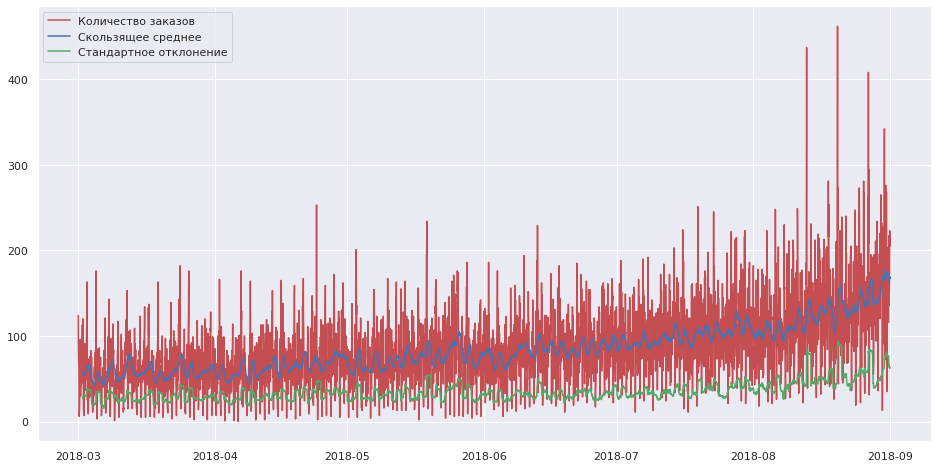

In [19]:
plot_roll(df_resample)
plt.plot(df_resample.rolling(24).std(), 'g', label='Стандартное отклонение')
plt.legend();

Из этого графика видно, что увеличиваются среднее значение и стандартное отклонение со временем, но не ясно - стационарный ряд или нет. Чтобы проверить ряд на стационарность, найдём разности его значений.

In [20]:
df_stat = df_resample['num_orders'] - df_resample['num_orders'].shift(fill_value=0)

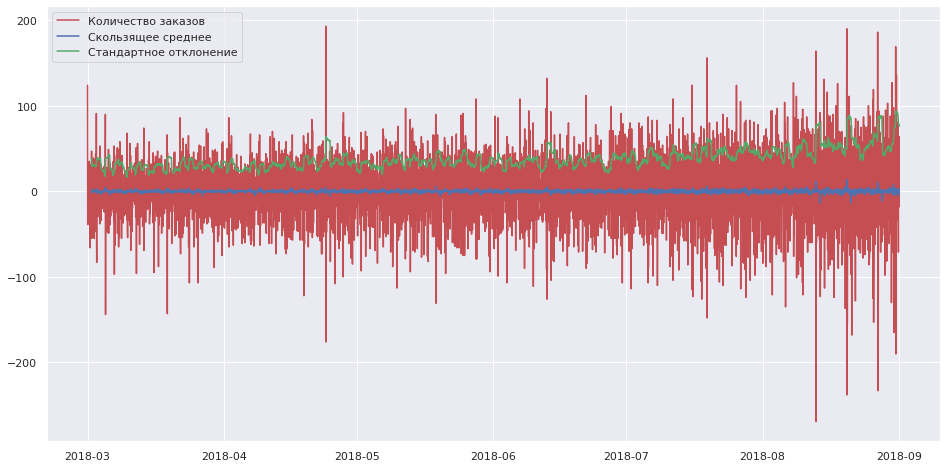

In [21]:
plot_roll(df_stat)
plt.plot(df_stat.rolling(24).std(), 'g', label='Стандартное отклонение')
plt.legend();

Среднее теперь не меняется - ряд стал стационарным => его можно спрогнозировать.

# 3 Подготовка и обучение моделей

Теперь нужно сгенерировать новые признаки. Добавим признаки с разным сдвигом, календарные признаки и скользящее среднее:

In [22]:
def get_new_features(data, max_lag, roll_1, roll_2):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    data['rolling_mean_1'] = data['num_orders'].shift().rolling(roll_1).mean()
    data['rolling_mean_2'] = data['num_orders'].shift().rolling(roll_2).mean()
    data.dropna(inplace=True)

Скопируем df_resample в новую переменную, которую и будем преобразовывать:

In [23]:
df = df_resample.copy()

Создадим новые признаки и удалим все пропуски:

In [24]:
get_new_features(df, 15, 12, 24)

In [25]:
df.head(5)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,rolling_mean_1,rolling_mean_2
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2018,3,2,4,58.0,113.0,66.0,61.0,45.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,56.583333,56.833333
2018-03-02 01:00:00,120,2018,3,2,4,90.0,58.0,113.0,66.0,61.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,61.583333,55.416667
2018-03-02 02:00:00,75,2018,3,2,4,120.0,90.0,58.0,113.0,66.0,...,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,68.916667,56.875000
2018-03-02 03:00:00,64,2018,3,2,4,75.0,120.0,90.0,58.0,113.0,...,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,71.166667,57.041667
2018-03-02 04:00:00,20,2018,3,2,4,64.0,75.0,120.0,90.0,58.0,...,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,71.000000,56.958333


Разобъем датасет на тестовую и обучающую выборки:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('num_orders', axis=1), df['num_orders'],
                                                    shuffle=False, test_size=0.1, random_state=42)

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3952, 21), (3952,), (440, 21), (440,))

Выберем классические модели - линейной регрессии, случайный лес и модель с бустингом (попробуем catboost). Также проверим модель на адекватность, сравнивая результаты с моделью, которая будет предсказывать медианное значение.

Создадим модели и проверим ошибку. Также для наглядности построим полученные предсказания на графике:

In [28]:
# случайная модель, предсказывающая медианное значение
model_dummy = DummyRegressor(strategy='median')

# модель линейной регрессии
model_reg = LinearRegression()

# модель случайного леса
model_rf = RandomForestRegressor(random_state=42)

# catboost
model_cat = CatBoostRegressor(silent=True, random_state=42)

Создадим функцию, которая будет считать метрику RMSE, по которой будем оценивать качество предсказаний:

In [29]:
def rmse(y_true, predict):
    return mean_squared_error(y_true, predict) ** 0.5

Добавим функцию для обучения и оценки качества моделей:

In [30]:
def model_train(model, name):
    print('-' * 12, f'Модель {name}', '-' * 12)
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    print(f'RMSE на тестовых данных равно: {rmse(y_test, predict)}')
    print('-' * 50)
    print()
    plt.figure(figsize=(16, 8))
    plt.plot(y_train, label='Обучающие данные')
    plt.plot(y_test, 'g', label='Реальные данные', alpha=0.5)
    plt.plot(pd.Series(predict, index=y_test.index), 'r', label='Предсказанные значения', alpha=0.8)    
    plt.title(name, fontsize=16)
    plt.legend()    
    plt.show()
    print('\n\n\n')
    print('*' * 50)

------------ Модель Случайная модель ------------
RMSE на тестовых данных равно: 87.21093811714634
--------------------------------------------------



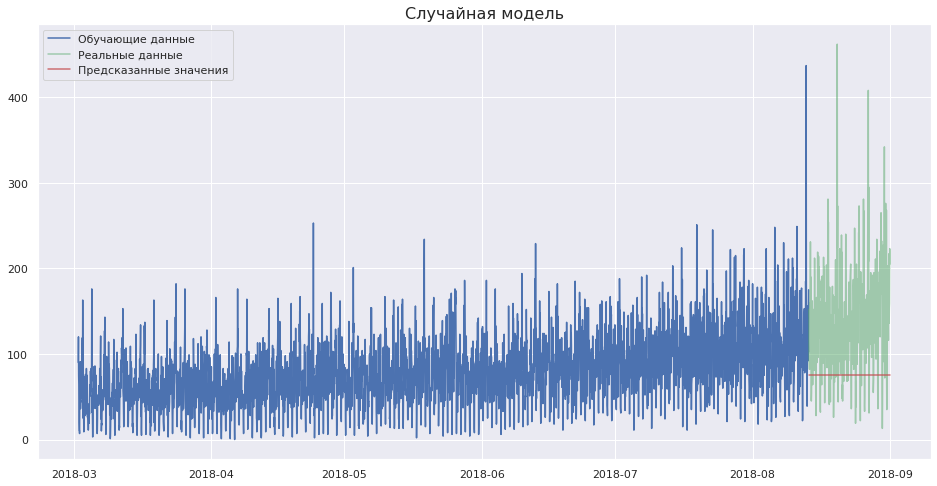





**************************************************
------------ Модель Линейная регрессия ------------
RMSE на тестовых данных равно: 50.574906837739306
--------------------------------------------------



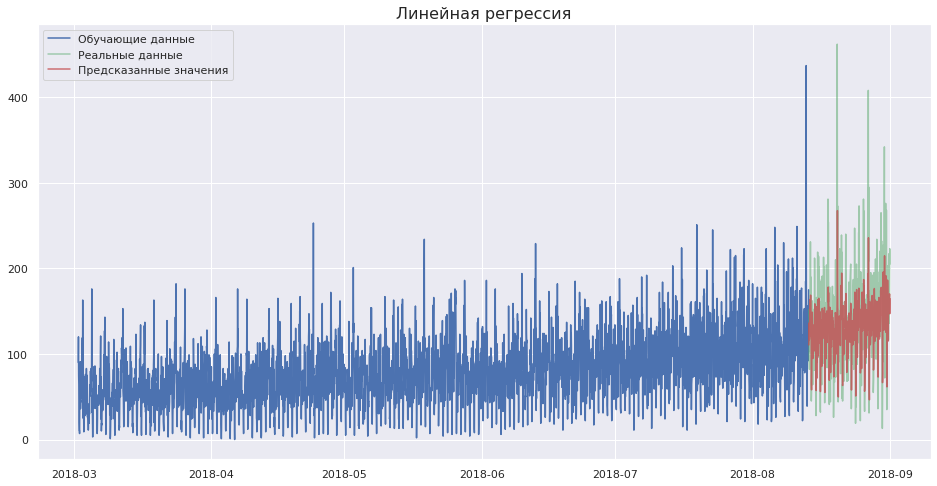





**************************************************
------------ Модель Случайный лес ------------


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE на тестовых данных равно: 54.602191514460465
--------------------------------------------------



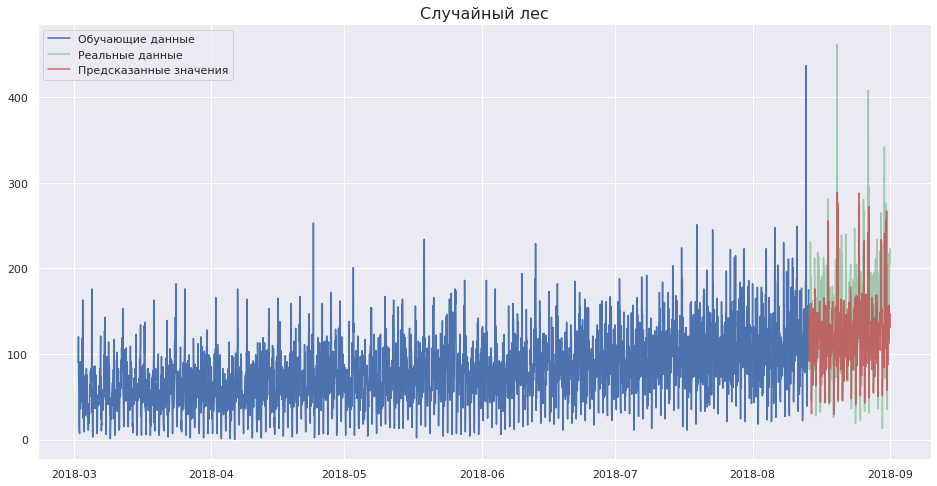





**************************************************
------------ Модель Бустер ------------
RMSE на тестовых данных равно: 48.68427639139401
--------------------------------------------------



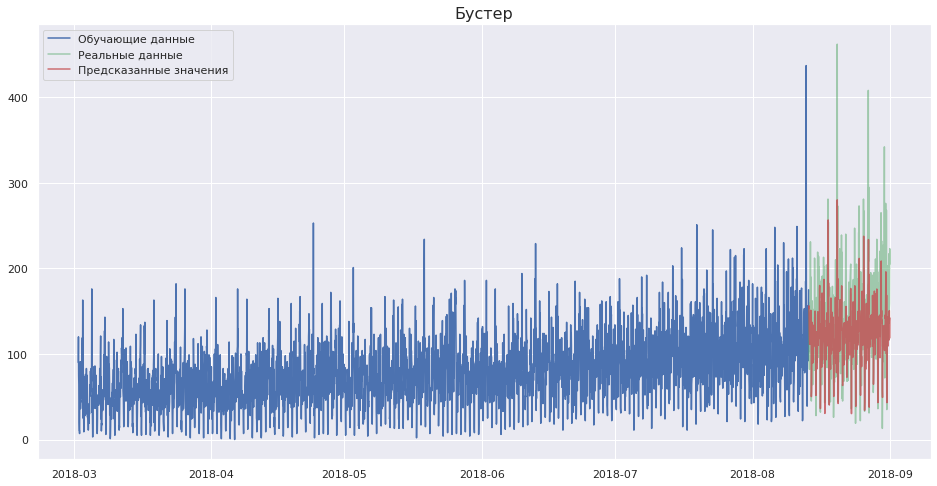





**************************************************


In [31]:
for i in ((model_dummy, 'Случайная модель'), 
          (model_reg, 'Линейная регрессия'), 
          (model_rf, 'Случайный лес'), 
          (model_cat, 'Бустер')):
    model_train(i[0], i[1])

### Выводы:

1. Без подбора гиперпараметров лучшая модель - модель CatBoost.
2. Случайная модель дает самый худший результат.
3. Значения RMSE, полученые по результатам предсказаний, не удовлетворяют цели проекта - подберем гиперпараметры бустера Catboost и дерева решений.
4. Подбор параметров нужно осуществить с использованием кроссвалидации.

# 4 Подбор гиперпараметров

Зададим параметры для бустера и модели случайного леса.

In [32]:
param_forest = {
    'n_estimators': range(10, 100, 10),
    'max_depth': range(3, 9), 
    'min_samples_leaf': range(3, 8),
}

param_cat = {
    'depth': range(3, 8)
}

Создаем метрику обучения:

In [33]:
rmse_score = make_scorer(rmse, greater_is_better=False)

In [34]:
grid_forest = GridSearchCV(model_rf, param_forest, scoring=rmse_score, verbose=10, cv=3)
grid_cat = GridSearchCV(model_cat, param_cat, scoring=rmse_score, verbose=10, cv=3)

In [35]:
%%time
for i in (grid_forest, grid_cat):
    i.fit(X_train, y_train)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
[CV] max_depth=3, min_samples_leaf=3, n_estimators=10 ................
[CV]  max_depth=3, min_samples_leaf=3, n_estimators=10, score=-28.841, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=10 ................
[CV]  max_depth=3, min_samples_leaf=3, n_estimators=10, score=-30.088, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=10 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=3, min_samples_leaf=3, n_estimators=10, score=-39.256, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=20 ................
[CV]  max_depth=3, min_samples_leaf=3, n_estimators=20, score=-28.904, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=20 ................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=3, min_samples_leaf=3, n_estimators=20, score=-30.145, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=20 ................
[CV]  max_depth=3, min_samples_leaf=3, n_estimators=20, score=-39.272, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=30 ................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s


[CV]  max_depth=3, min_samples_leaf=3, n_estimators=30, score=-29.021, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=30 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


[CV]  max_depth=3, min_samples_leaf=3, n_estimators=30, score=-30.177, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=30 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=3, min_samples_leaf=3, n_estimators=30, score=-39.536, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=40 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.5s remaining:    0.0s


[CV]  max_depth=3, min_samples_leaf=3, n_estimators=40, score=-28.834, total=   0.3s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=40 ................
[CV]  max_depth=3, min_samples_leaf=3, n_estimators=40, score=-30.193, total=   0.3s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=40 ................
[CV]  max_depth=3, min_samples_leaf=3, n_estimators=40, score=-39.624, total=   0.3s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=50 ................
[CV]  max_depth=3, min_samples_leaf=3, n_estimators=50, score=-28.796, total=   0.4s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=50 ................
[CV]  max_depth=3, min_samples_leaf=3, n_estimators=50, score=-30.135, total=   0.4s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=50 ................
[CV]  max_depth=3, min_samples_leaf=3, n_estimators=50, score=-39.525, total=   0.4s
[CV] max_depth=3, min_samples_leaf=3, n_estimators=60 ................
[CV]  max_depth=3, min_samples_leaf=3, n_estimators=60, score=-2

[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:  8.9min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] depth=3 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................... depth=3, score=-25.950, total=  12.6s
[CV] depth=3 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s


[CV] ........................... depth=3, score=-26.794, total=  13.3s
[CV] depth=3 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.9s remaining:    0.0s


[CV] ........................... depth=3, score=-35.587, total=  13.4s
[CV] depth=4 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.3s remaining:    0.0s


[CV] ........................... depth=4, score=-26.056, total=  16.7s
[CV] depth=4 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   56.0s remaining:    0.0s


[CV] ........................... depth=4, score=-26.517, total=  17.4s
[CV] depth=4 .........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[CV] ........................... depth=4, score=-35.240, total=  17.4s
[CV] depth=5 .........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.5min remaining:    0.0s


[CV] ........................... depth=5, score=-25.941, total=  22.1s
[CV] depth=5 .........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.9min remaining:    0.0s


[CV] ........................... depth=5, score=-26.112, total=  21.7s
[CV] depth=5 .........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.2min remaining:    0.0s


[CV] ........................... depth=5, score=-35.370, total=  20.8s
[CV] depth=6 .........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.6min remaining:    0.0s


[CV] ........................... depth=6, score=-25.987, total=  28.6s
[CV] depth=6 .........................................................
[CV] ........................... depth=6, score=-26.028, total=  30.9s
[CV] depth=6 .........................................................
[CV] ........................... depth=6, score=-36.084, total=  26.6s
[CV] depth=7 .........................................................
[CV] ........................... depth=7, score=-25.999, total=  35.9s
[CV] depth=7 .........................................................
[CV] ........................... depth=7, score=-25.843, total=  37.4s
[CV] depth=7 .........................................................
[CV] ........................... depth=7, score=-35.950, total=  35.5s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.8min finished


CPU times: user 13min 35s, sys: 46.3 s, total: 14min 21s
Wall time: 15min 12s


In [36]:
grid_forest.best_params_

{'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 90}

In [37]:
grid_cat.best_params_

{'depth': 5}

Посмотрим на результаты

------------ Модель Случайный лес ------------
RMSE на тестовых данных равно: 51.67594816323439
--------------------------------------------------



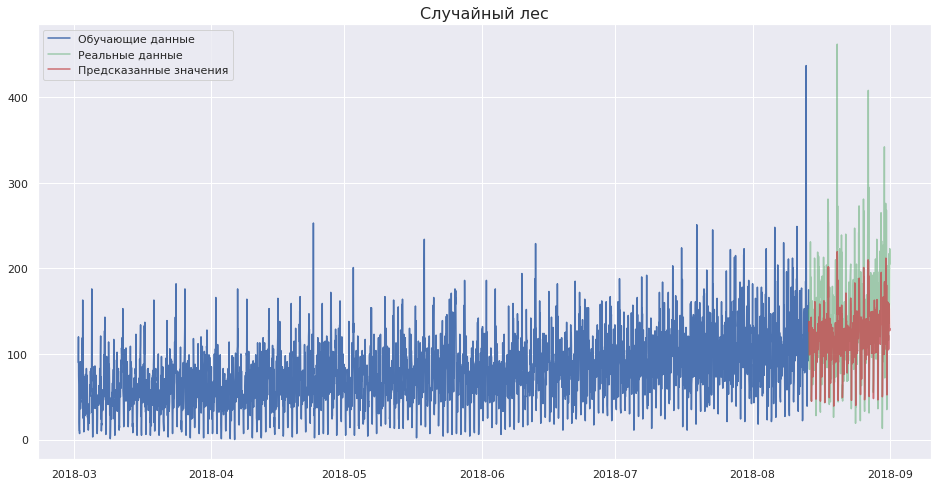





**************************************************


In [38]:
model_train(grid_forest.best_estimator_, 'Случайный лес')

------------ Модель Модель Catboost ------------
RMSE на тестовых данных равно: 48.82734724298972
--------------------------------------------------



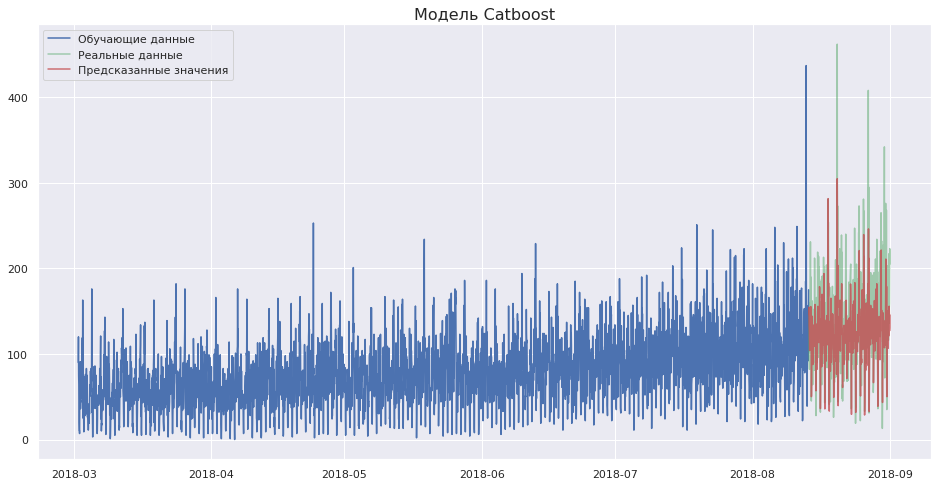





**************************************************


In [39]:
model_train(grid_cat.best_estimator_, 'Модель Catboost')

Качество предсказаний CatBoost всё равно лучше - подберем еще какие-нибудь параметры только ему.

In [40]:
param_cat_2 = {
    'depth': [6, 7],
    'l2_leaf_reg': [1.1],
    'learning_rate': [0.03],
    'iterations': [5000, 6000]
}

In [41]:
grid_cat_2 = GridSearchCV(model_cat, param_cat_2, scoring=rmse_score, verbose=10, cv=3)

In [42]:
%%time
grid_cat_2.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03, score=-27.456, total= 2.2min
[CV] depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV]  depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03, score=-25.756, total= 2.3min
[CV] depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03 ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.5min remaining:    0.0s


[CV]  depth=6, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03, score=-35.953, total= 2.1min
[CV] depth=6, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03 ...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.6min remaining:    0.0s


[CV]  depth=6, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03, score=-27.482, total= 2.7min
[CV] depth=6, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03 ...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.3min remaining:    0.0s


[CV]  depth=6, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03, score=-25.775, total= 2.5min
[CV] depth=6, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03 ...


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.8min remaining:    0.0s


[CV]  depth=6, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03, score=-35.972, total= 2.5min
[CV] depth=7, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03 ...


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 14.3min remaining:    0.0s


[CV]  depth=7, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03, score=-26.945, total= 2.9min
[CV] depth=7, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03 ...


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 17.2min remaining:    0.0s


[CV]  depth=7, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03, score=-25.766, total= 2.9min
[CV] depth=7, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03 ...


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 20.1min remaining:    0.0s


[CV]  depth=7, iterations=5000, l2_leaf_reg=1.1, learning_rate=0.03, score=-36.072, total= 2.8min
[CV] depth=7, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03 ...


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 22.9min remaining:    0.0s


[CV]  depth=7, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03, score=-26.950, total= 3.6min
[CV] depth=7, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03 ...
[CV]  depth=7, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03, score=-25.764, total= 3.6min
[CV] depth=7, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03 ...
[CV]  depth=7, iterations=6000, l2_leaf_reg=1.1, learning_rate=0.03, score=-36.081, total= 3.3min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 33.3min finished


CPU times: user 30min 23s, sys: 5min 10s, total: 35min 33s
Wall time: 36min 22s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f5eee969850>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [6, 7], 'iterations': [5000, 6000],
                         'l2_leaf_reg': [1.1], 'learning_rate': [0.03]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(rmse, greater_is_better=False), verbose=10)

In [43]:
grid_cat_2.best_params_

{'depth': 7, 'iterations': 5000, 'l2_leaf_reg': 1.1, 'learning_rate': 0.03}

------------ Модель Модель Catboost ------------
RMSE на тестовых данных равно: 48.324988343039465
--------------------------------------------------



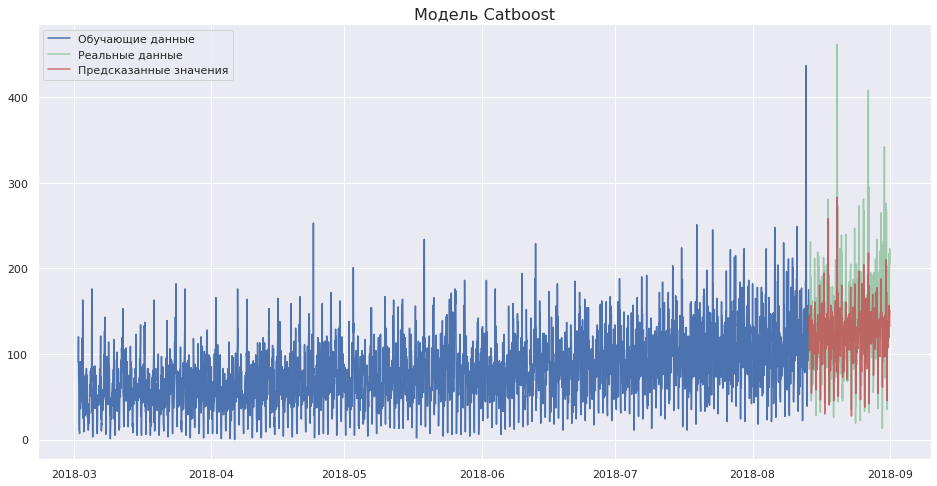





**************************************************


In [44]:
model_train(grid_cat_2.best_estimator_, 'Модель Catboost')

### Вывод

В ходе проекта проанализированы 4 разные модели и получены следующие результаты RMSE на тестовой выборке:
- Случайная модель = 87.2
- Линейная регрессия = 50.57
После настройки гиперпараметров:
- Случайный лес = 51.7
- Модель, использующая градиентный бустинг (CatBoost) = 47.98

Цель проекта выполнена, получена модель со значением RMSE < 48 - модель CatBoost.

In [45]:
# копируем исходный датасет
df_for_lin = df_resample.copy()

In [46]:
get_new_features(df_for_lin, 25, 12, 24)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_for_lin.drop('num_orders', axis=1), df_for_lin['num_orders'],
                                                    shuffle=False, test_size=0.1, random_state=42)

RMSE на тестовых данных равно: 45.68738572668906
--------------------------------------------------



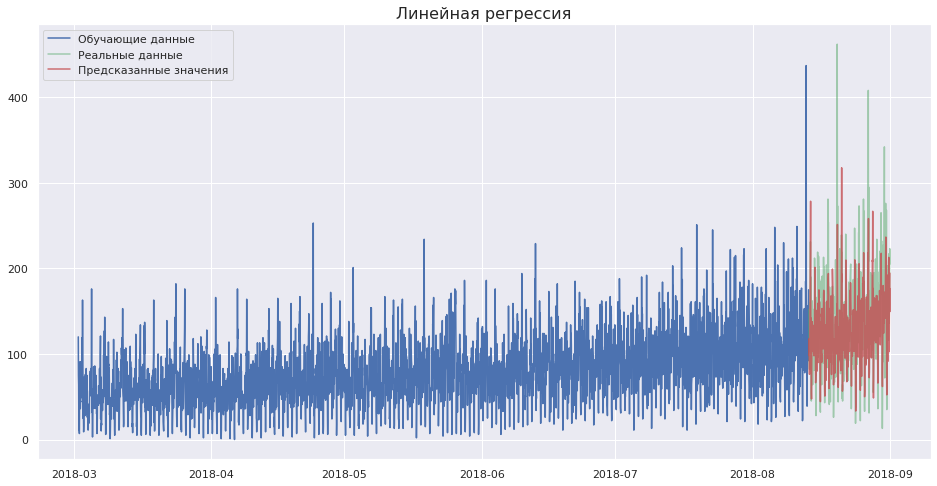

In [48]:
# обучаем модель и строим график

model_reg.fit(X_train, y_train)
predict = model_reg.predict(X_test)
print(f'RMSE на тестовых данных равно: {rmse(y_test, predict)}')
print('-' * 50)
print()
plt.figure(figsize=(16, 8))
plt.plot(y_train, label='Обучающие данные')
plt.plot(y_test, 'g', label='Реальные данные', alpha=0.5)
plt.plot(pd.Series(predict, index=y_test.index), 'r', label='Предсказанные значения', alpha=0.8)    
plt.title('Линейная регрессия', fontsize=16)
plt.legend();

### Вывод

При достаточно большом количестве созданных признаков модель линейной регресси удовлетворяет цели проекта - ее RMSE = 45.7 < 48.